# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/albumentations-team/albumentations to c:\users\deola\appdata\local\temp\pip-req-build-buyqwqq9
  Resolved https://github.com/albumentations-team/albumentations to commit eaa1b5f7c4d53ad95e1b8148b5d2d88d34a4ca40
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\deola\AppData\Local\Temp\pip-req-build-buyqwqq9'

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

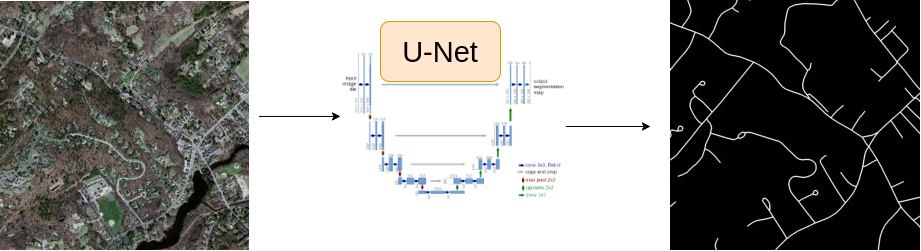

# Download Subset Dataset

In [5]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
error: RPC failed; curl 92 HTTP/2 stream 5 was not closed cleanly: CANCEL (err 8)
error: 10 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output


# Some Common Imports

In [5]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [49]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from Road_seg_dataset import helper

# Task : 2 Setup Configurations

In [18]:
CSV_FILE = 'Road_seg_dataset/train.csv'
DATA_DIR = 'Road_seg_dataset'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'efficientnet-b0'
WEIGHTS = 'imagenet'

In [19]:
df = pd.read_csv('Road_seg_dataset/train.csv')
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [20]:
import os

idx = 15
row = df.iloc[idx]

# Ensure DATA_DIR ends with a slash
DATA_DIR = os.path.join(DATA_DIR, "")

# Construct full paths
image_path = os.path.join(DATA_DIR, row.images)
mask_path = os.path.join(DATA_DIR, row.masks)

# Debugging: Print paths
print(f"Image path: {image_path}")
print(f"Mask path: {mask_path}")

# Check file existence
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask file not found at {mask_path}")

# Read and process image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image at {image_path}. Check file path and format.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read and process mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise ValueError(f"Failed to load mask at {mask_path}. Check file path and format.")
mask = mask / 255

Image path: Road_seg_dataset\images/10978660_15.png
Mask path: Road_seg_dataset\masks/10978660_15.png


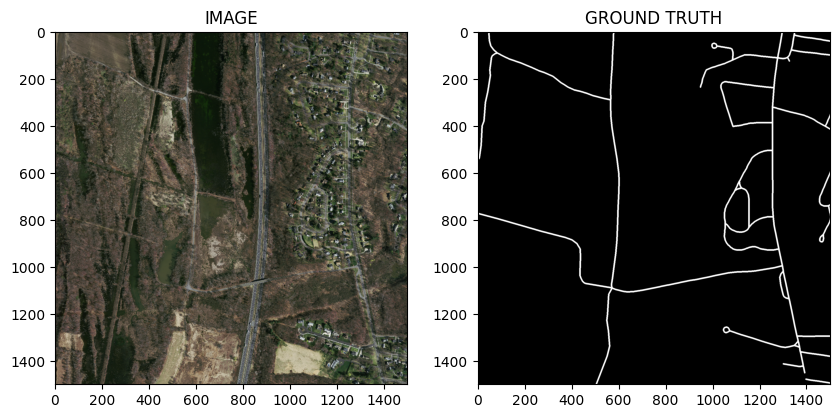

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [22]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [23]:
import albumentations as A

In [25]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [26]:
from torch.utils.data import Dataset

In [27]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]

      image_path = os.path.join(DATA_DIR, row.images)
      mask_path = os.path.join(DATA_DIR, row.masks)

      if not os.path.exists(image_path):
          raise FileNotFoundError(f"Image file not found: {image_path}")
      if not os.path.exists(mask_path):
          raise FileNotFoundError(f"Mask file not found: {mask_path}")

      image = cv2.imread(image_path)
      if image is None:
          raise ValueError(f"Failed to read image: {image_path}")

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      if mask is None:
          raise ValueError(f"Failed to read mask: {mask_path}")

      mask = np.expand_dims(mask, axis=-1)

      # Continue with augmentations if applicable
      if self.augmentations:
          data = self.augmentations(image=image, mask=mask)
          image = data['image']
          mask = data['mask']

      # Convert to PyTorch tensors
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [28]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [31]:
idx = 5
image,mask = trainset[idx]

helper.show_image(image,mask)

NameError: name 'helper' is not defined

In [32]:
print(f"Size of trainset {len(trainset)}")
print(f"Size of validset {len(validset)}")

Size of trainset 159
Size of validset 40


# Task 5 : Load dataset into batches

In [33]:
from torch.utils.data import DataLoader

In [34]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [35]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [36]:
for images, masks in trainloader:
  print(images.shape)
  print(masks.shape)
  break;

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [37]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [38]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks= None ):

      logits = self.backbone(images)

      if masks != None:
        return logits, DiceLoss(mode= 'binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)
      return logits

In [39]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\deola/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:18<00:00, 1.15MB/s]


# Task 7 : Create Train and Validation Function

In [40]:
def train_fn(dataloader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [41]:
def eval_fn(dataloader, model):

  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [43]:
best_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_loss = valid_loss

  print(f'Epoch : {i+1}')
  print(f'Train Loss : {train_loss}')
  print(f'Valid Loss : {valid_loss}')

100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Saved Model
Epoch : 1
Train Loss : 1.1961680144071578
Valid Loss : 1.0704145431518555


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch : 2
Train Loss : 0.7735652774572372
Valid Loss : 1.50370352268219


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch : 3
Train Loss : 0.7053652226924896
Valid Loss : 2.747282361984253


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch : 4
Train Loss : 0.6712297141551972
Valid Loss : 1.233715796470642


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch : 5
Train Loss : 0.640357717871666
Valid Loss : 1.2163127183914184


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch : 6
Train Loss : 0.635408166050911
Valid Loss : 1.1481828927993774


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Saved Model
Epoch : 7
Train Loss : 0.626110377907753
Valid Loss : 0.9995490550994873


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Saved Model
Epoch : 8
Train Loss : 0.6397768169641495
Valid Loss : 0.8349878907203674


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch : 9
Train Loss : 0.6210141241550445
Valid Loss : 1.0137404918670654


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch : 10
Train Loss : 0.6150994777679444
Valid Loss : 1.0749510288238526


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch : 11
Train Loss : 0.6158360183238983
Valid Loss : 1.0137935876846313


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch : 12
Train Loss : 0.6226185202598572
Valid Loss : 0.8511203289031982


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch : 13
Train Loss : 0.6120112031698227
Valid Loss : 0.8921738028526306


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch : 14
Train Loss : 0.6042610049247742
Valid Loss : 1.0949309825897218


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch : 15
Train Loss : 0.589991545677185
Valid Loss : 1.1469569444656371


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Saved Model
Epoch : 16
Train Loss : 0.5861778631806374
Valid Loss : 0.7802693843841553


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch : 17
Train Loss : 0.5744060277938843
Valid Loss : 1.0331448674201966


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch : 18
Train Loss : 0.5826554670929909
Valid Loss : 1.2027851343154907


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch : 19
Train Loss : 0.5695353806018829
Valid Loss : 0.8775532364845275


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Saved Model
Epoch : 20
Train Loss : 0.5714683398604393
Valid Loss : 0.7114791631698608


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch : 21
Train Loss : 0.5612527713179588
Valid Loss : 0.7316691040992737


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch : 22
Train Loss : 0.5636139765381813
Valid Loss : 0.7349066615104676


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Saved Model
Epoch : 23
Train Loss : 0.5694705873727799
Valid Loss : 0.6768159151077271


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch : 24
Train Loss : 0.5662071332335472
Valid Loss : 0.7377321124076843


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

Epoch : 25
Train Loss : 0.5616129592061043
Valid Loss : 0.6824823141098022


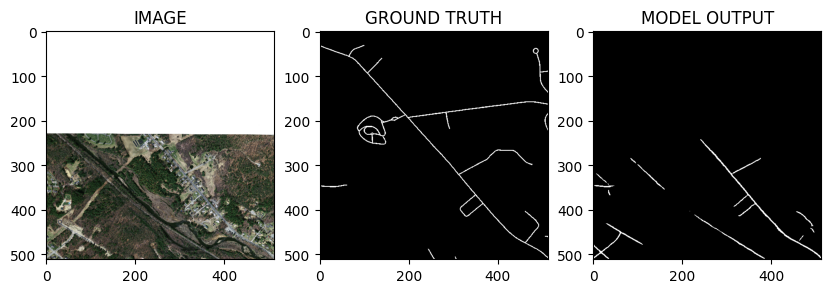

In [76]:
idx = 11

model.load_state_dict(torch.load('best_model.pt', weights_only=True))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

helper.show_image(image, mask,pred_mask.detach().cpu().squeeze(0))

Uploaded image shape: torch.Size([3, 256, 256])
Model output shape: torch.Size([1, 1, 256, 256])


AttributeError: 'NoneType' object has no attribute 'squeeze'

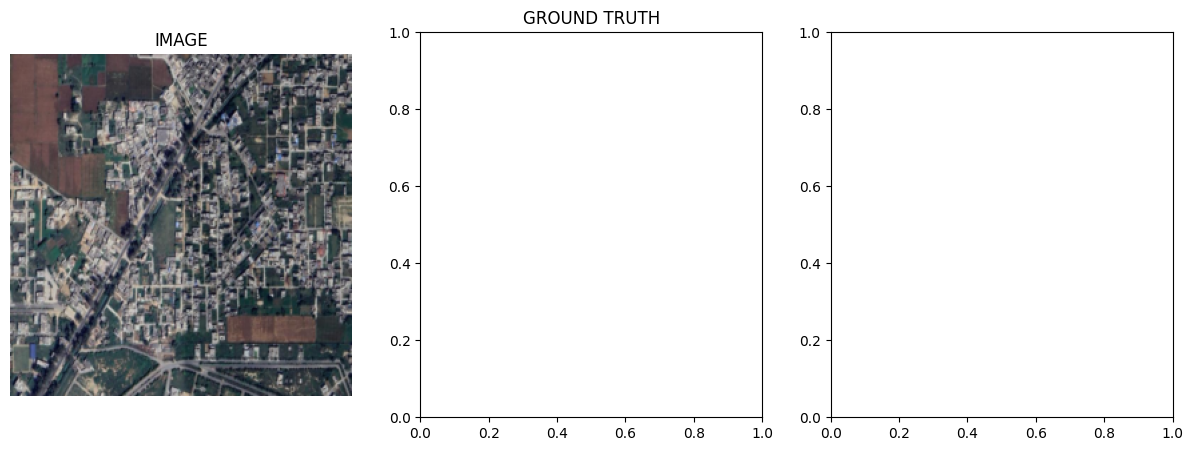

In [67]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from Road_seg_dataset.helper_extension import show_image  # Import show_image from helper_extension

# Load the model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
model.eval()  # Set the model to evaluation mode

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure DEVICE is defined

# Preprocess function
def preprocess_image(image_path, transform=None):
    """Loads an image, converts it to RGB, and applies transformations."""
    image = Image.open(image_path).convert('RGB')  # Load and convert to RGB
    if transform:
        image = transform(image)  # Apply transformations
    return image

# Transform pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model input size
    transforms.ToTensor(),         # Convert image to tensor
])

# Load and preprocess image
image_path = 'Custom_images/img.png'  # Replace with your image path
uploaded_image = preprocess_image(image_path, transform=transform).to(DEVICE)  # Move to DEVICE
print(f"Uploaded image shape: {uploaded_image.shape}")  # [3, 256, 256]

# Get model predictions
logits_mask = model(uploaded_image.unsqueeze(0))  # Add batch dimension
print(f"Model output shape: {logits_mask.shape}")  # [1, 1, 256, 256]

# Process prediction mask
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

# Prepare for visualization
# Correct the permutation order to [Height, Width, Channels]
image_for_visualization = uploaded_image.cpu().permute(1, 2, 0).numpy()  # [256, 256, 3]
pred_mask_for_visualization = pred_mask.detach().cpu().squeeze(0).squeeze(0).numpy()  # [256, 256]

# Ground truth mask (optional, set to None if not available)
mask_for_visualization = None  # Replace this with your ground truth mask if available

# Visualize
show_image(image_for_visualization, mask_for_visualization, pred_mask_for_visualization)
